In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 20

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -50
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 0  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10 #10
NEGATIVE_REWARD_DIVIDE = 3 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}

osmdesat = 35

In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0.45  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        
        self.learning_rate = 0.000815
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > osmdesat * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


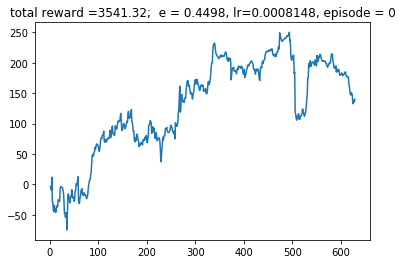

Waiting to train the whole dataset
action0:  368 
action1:  285 
action2:  1327
DONE, lets roll!!
94.086
More than 35 on candle 906


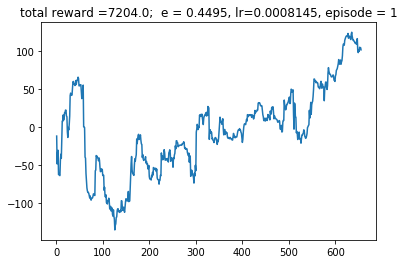

Waiting to train the whole dataset
action0:  295 
action1:  300 
action2:  1385
DONE, lets roll!!
106.561
More than 35 on candle 115
More than 35 on candle 1674


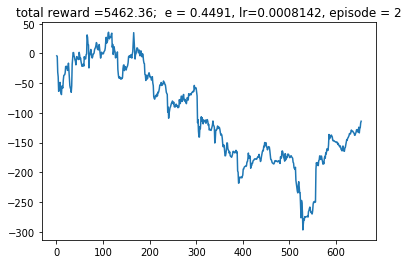

Waiting to train the whole dataset
action0:  285 
action1:  279 
action2:  1416
DONE, lets roll!!
81.397
More than 35 on candle 115
More than 35 on candle 506
More than 35 on candle 1682


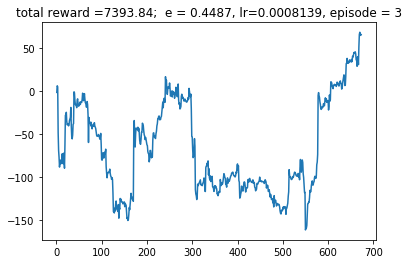

Waiting to train the whole dataset
action0:  284 
action1:  295 
action2:  1401
DONE, lets roll!!
82.808
More than 35 on candle 214


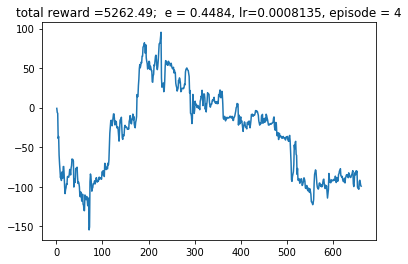

Waiting to train the whole dataset
action0:  295 
action1:  286 
action2:  1399
DONE, lets roll!!
83.801
More than 35 on candle 505


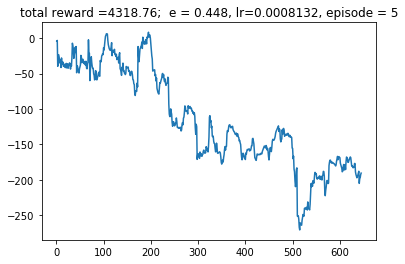

Waiting to train the whole dataset
action0:  294 
action1:  288 
action2:  1398
DONE, lets roll!!
82.099
More than 35 on candle 513
More than 35 on candle 1675


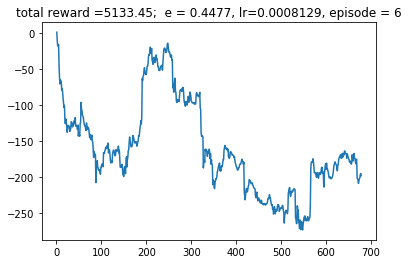

Waiting to train the whole dataset
action0:  285 
action1:  305 
action2:  1390
DONE, lets roll!!
85.633
More than 35 on candle 120
More than 35 on candle 504


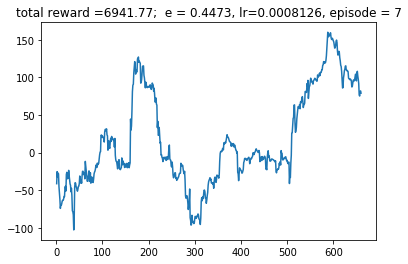

Waiting to train the whole dataset
action0:  279 
action1:  303 
action2:  1398
DONE, lets roll!!
86.152
More than 35 on candle 117
More than 35 on candle 213


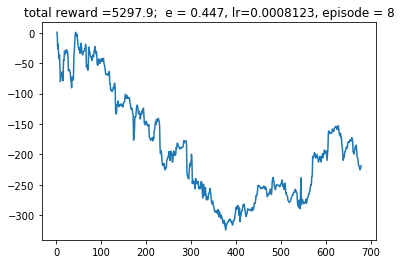

Waiting to train the whole dataset
action0:  282 
action1:  305 
action2:  1393
DONE, lets roll!!
79.078
More than 35 on candle 214
More than 35 on candle 505


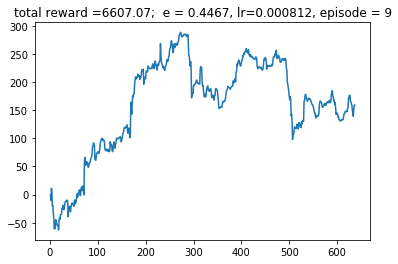

Waiting to train the whole dataset
action0:  286 
action1:  289 
action2:  1405
DONE, lets roll!!
76.503
More than 35 on candle 212
More than 35 on candle 507
More than 35 on candle 904
More than 35 on candle 1676


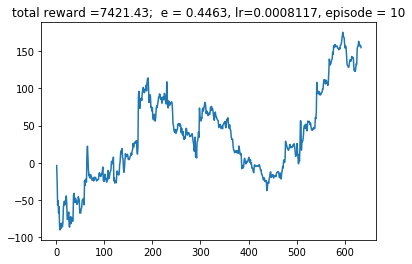

Waiting to train the whole dataset
action0:  285 
action1:  293 
action2:  1402
DONE, lets roll!!
75.908
More than 35 on candle 213
More than 35 on candle 504


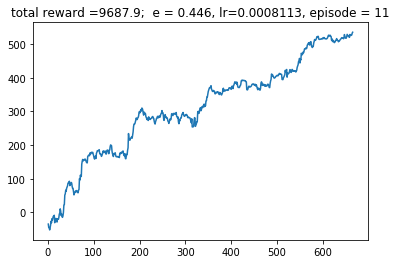

Waiting to train the whole dataset
action0:  297 
action1:  301 
action2:  1382
DONE, lets roll!!
77.289
More than 35 on candle 505


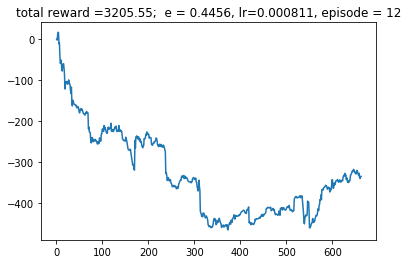

Waiting to train the whole dataset
action0:  308 
action1:  284 
action2:  1388
DONE, lets roll!!
80.889


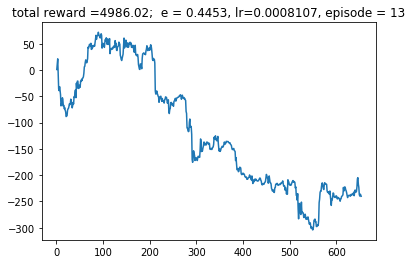

Waiting to train the whole dataset
action0:  293 
action1:  291 
action2:  1396
DONE, lets roll!!
75.178
More than 35 on candle 1487


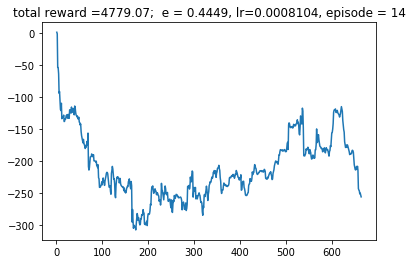

Waiting to train the whole dataset
action0:  274 
action1:  882 
action2:  824
DONE, lets roll!!
75.413
More than 35 on candle 1675


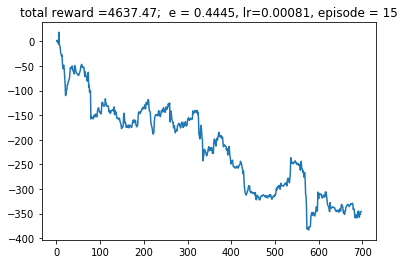

Waiting to train the whole dataset
action0:  285 
action1:  311 
action2:  1384
DONE, lets roll!!
75.502
More than 35 on candle 124
More than 35 on candle 212
More than 35 on candle 505


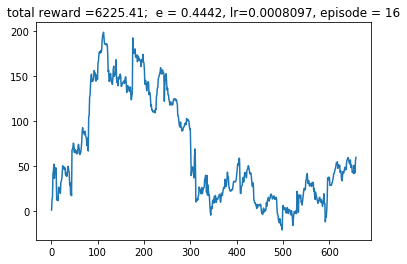

Waiting to train the whole dataset
action0:  296 
action1:  270 
action2:  1414
DONE, lets roll!!
74.569
More than 35 on candle 506
More than 35 on candle 904


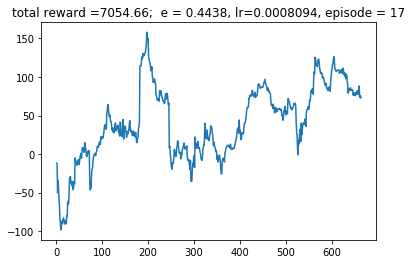

Waiting to train the whole dataset
action0:  273 
action1:  289 
action2:  1418
DONE, lets roll!!
74.154
More than 35 on candle 115
More than 35 on candle 506
More than 35 on candle 1682


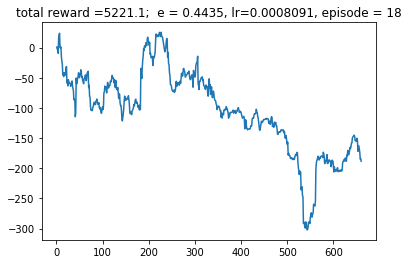

Waiting to train the whole dataset
action0:  276 
action1:  296 
action2:  1408
DONE, lets roll!!
74.535
More than 35 on candle 117
More than 35 on candle 213
More than 35 on candle 504
More than 35 on candle 904
More than 35 on candle 1575
More than 35 on candle 1673


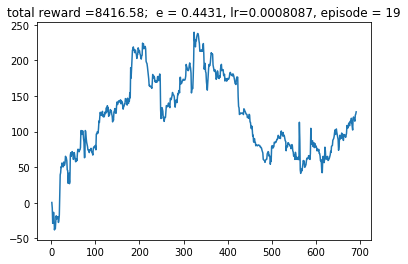

Waiting to train the whole dataset
action0:  268 
action1:  330 
action2:  1382
DONE, lets roll!!
74.996
More than 35 on candle 116
More than 35 on candle 505


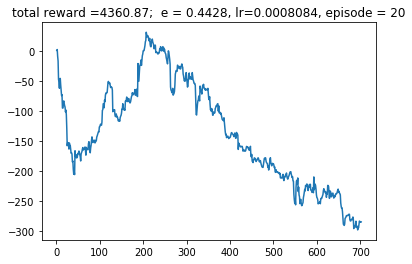

Waiting to train the whole dataset
action0:  277 
action1:  325 
action2:  1378
DONE, lets roll!!
75.565
More than 35 on candle 216
More than 35 on candle 504


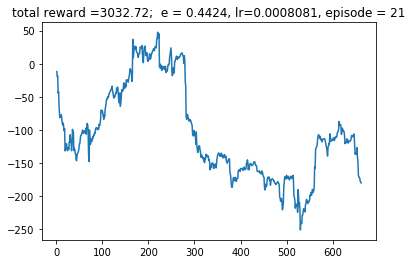

Waiting to train the whole dataset
action0:  311 
action1:  285 
action2:  1384
DONE, lets roll!!
74.231
More than 35 on candle 115
More than 35 on candle 504


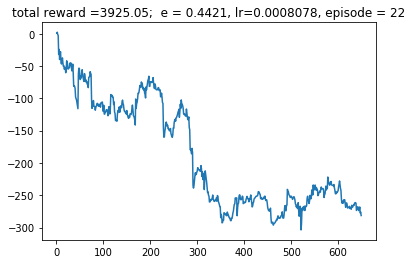

Waiting to train the whole dataset
action0:  295 
action1:  281 
action2:  1404
DONE, lets roll!!
75.17
More than 35 on candle 115
More than 35 on candle 206
More than 35 on candle 217
More than 35 on candle 510


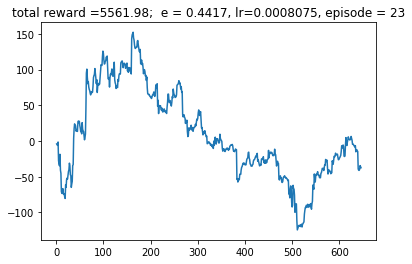

Waiting to train the whole dataset
action0:  303 
action1:  277 
action2:  1400
DONE, lets roll!!
74.435
More than 35 on candle 117
More than 35 on candle 505
More than 35 on candle 1573


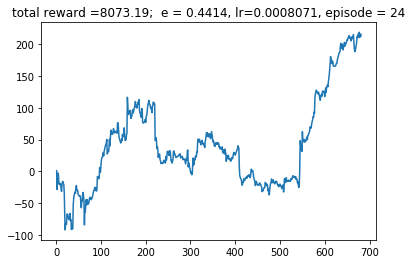

Waiting to train the whole dataset
action0:  290 
action1:  304 
action2:  1386
DONE, lets roll!!
77.102
More than 35 on candle 504
More than 35 on candle 1673


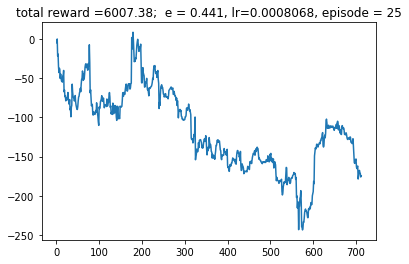

Waiting to train the whole dataset
action0:  302 
action1:  316 
action2:  1362
DONE, lets roll!!
74.249
More than 35 on candle 214
More than 35 on candle 506
More than 35 on candle 1575


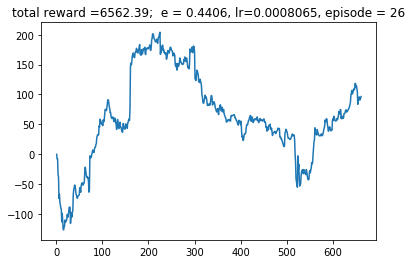

Waiting to train the whole dataset
action0:  311 
action1:  289 
action2:  1380
DONE, lets roll!!
74.086
More than 35 on candle 115
More than 35 on candle 505
More than 35 on candle 1576


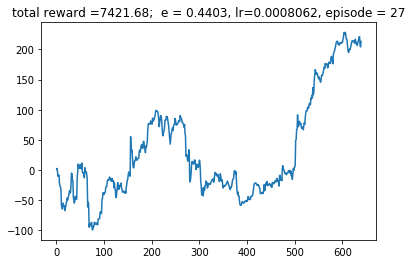

Waiting to train the whole dataset
action0:  290 
action1:  266 
action2:  1424
DONE, lets roll!!
75.296
More than 35 on candle 117
More than 35 on candle 504


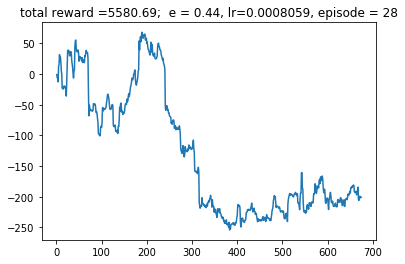

Waiting to train the whole dataset
action0:  290 
action1:  298 
action2:  1392
DONE, lets roll!!
74.271
More than 35 on candle 218


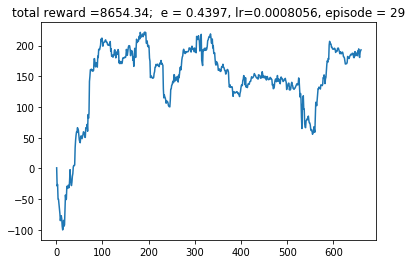

Waiting to train the whole dataset
action0:  299 
action1:  262 
action2:  1419
DONE, lets roll!!
75.214
More than 35 on candle 119
More than 35 on candle 509
More than 35 on candle 904
More than 35 on candle 1675


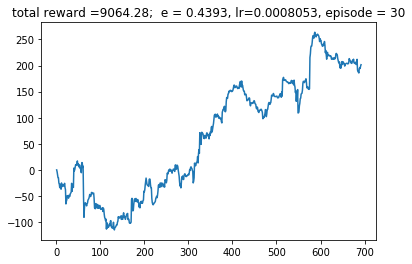

Waiting to train the whole dataset
action0:  277 
action1:  317 
action2:  1386
DONE, lets roll!!
74.432
More than 35 on candle 124
More than 35 on candle 213
More than 35 on candle 1671


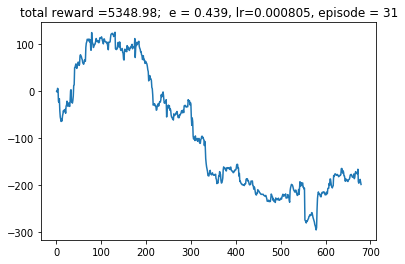

Waiting to train the whole dataset
action0:  287 
action1:  308 
action2:  1385
DONE, lets roll!!
74.688
More than 35 on candle 213
More than 35 on candle 507
More than 35 on candle 1674


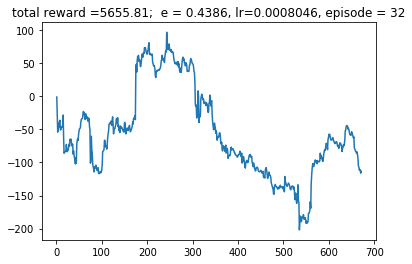

Waiting to train the whole dataset
action0:  318 
action1:  284 
action2:  1378
DONE, lets roll!!
74.584
More than 35 on candle 115
More than 35 on candle 504
More than 35 on candle 904
More than 35 on candle 1573


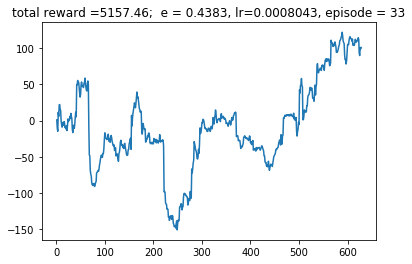

Waiting to train the whole dataset
action0:  300 
action1:  277 
action2:  1403
DONE, lets roll!!
74.295
More than 35 on candle 214
More than 35 on candle 504
More than 35 on candle 1675


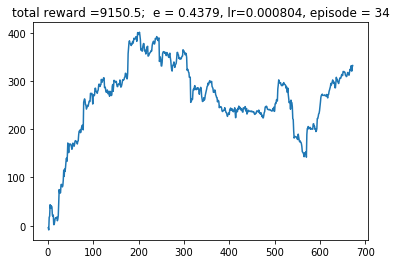

Waiting to train the whole dataset
action0:  274 
action1:  284 
action2:  1422
DONE, lets roll!!
74.057
More than 35 on candle 504


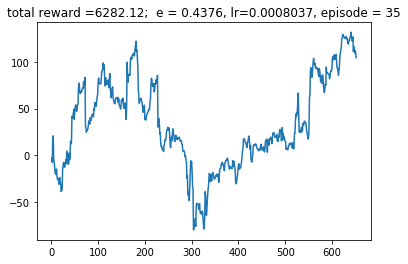

Waiting to train the whole dataset
action0:  268 
action1:  285 
action2:  1427
DONE, lets roll!!
75.354
More than 35 on candle 505


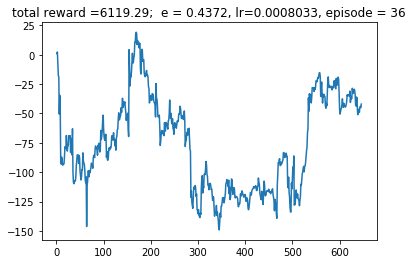

Waiting to train the whole dataset
action0:  292 
action1:  285 
action2:  1403
DONE, lets roll!!
74.41
More than 35 on candle 504
More than 35 on candle 1579
More than 35 on candle 1672


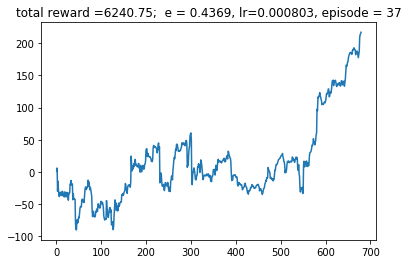

Waiting to train the whole dataset
action0:  263 
action1:  311 
action2:  1406
DONE, lets roll!!
74.096
More than 35 on candle 220
More than 35 on candle 504
More than 35 on candle 1573


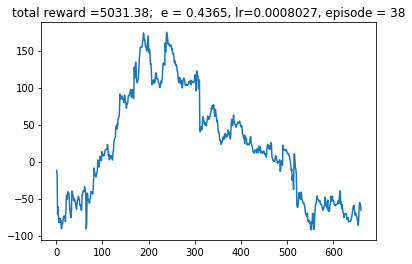

Waiting to train the whole dataset
action0:  308 
action1:  525 
action2:  1147
DONE, lets roll!!
75.491
More than 35 on candle 16
More than 35 on candle 205
More than 35 on candle 506
More than 35 on candle 905
More than 35 on candle 1588


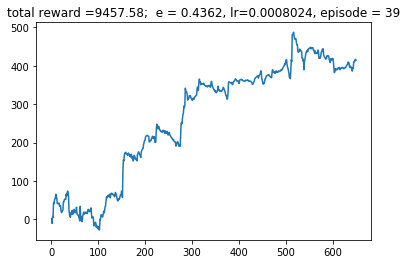

Waiting to train the whole dataset
action0:  285 
action1:  1426 
action2:  269
DONE, lets roll!!
74.899
More than 35 on candle 695
More than 35 on candle 905
More than 35 on candle 1584


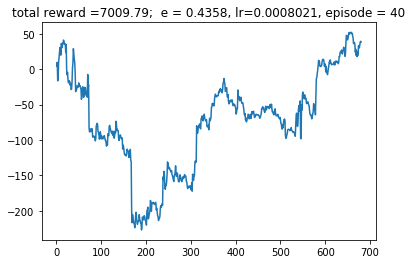

Waiting to train the whole dataset
action0:  301 
action1:  1262 
action2:  417
DONE, lets roll!!
73.82
More than 35 on candle 122
More than 35 on candle 215
More than 35 on candle 505


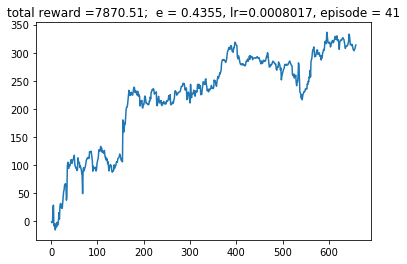

Waiting to train the whole dataset
action0:  297 
action1:  288 
action2:  1395
DONE, lets roll!!
73.805
More than 35 on candle 117
More than 35 on candle 211
More than 35 on candle 504
More than 35 on candle 906


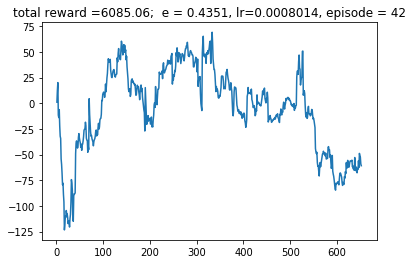

Waiting to train the whole dataset
action0:  278 
action1:  1350 
action2:  352
DONE, lets roll!!
73.413
More than 35 on candle 206
More than 35 on candle 913


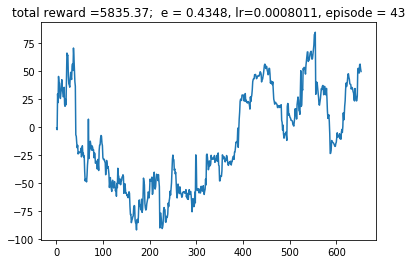

Waiting to train the whole dataset
action0:  315 
action1:  1232 
action2:  433
DONE, lets roll!!
74.409
More than 35 on candle 206
More than 35 on candle 878


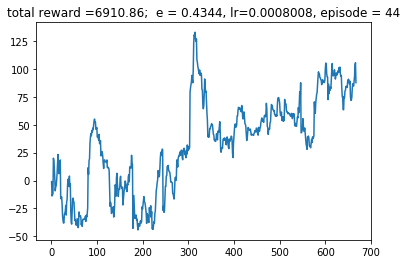

Waiting to train the whole dataset
action0:  294 
action1:  763 
action2:  923
DONE, lets roll!!
73.204
More than 35 on candle 215
More than 35 on candle 504


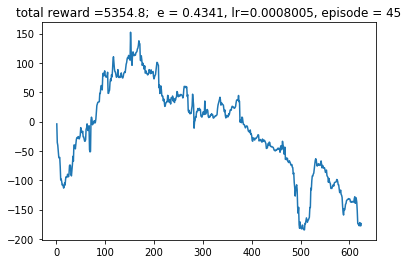

Waiting to train the whole dataset
action0:  258 
action1:  275 
action2:  1447
DONE, lets roll!!
74.768
More than 35 on candle 115
More than 35 on candle 223
More than 35 on candle 1578


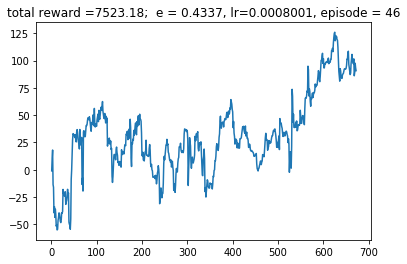

Waiting to train the whole dataset
action0:  307 
action1:  307 
action2:  1366
DONE, lets roll!!
74.44
More than 35 on candle 115
More than 35 on candle 222
More than 35 on candle 504
More than 35 on candle 904
More than 35 on candle 1585


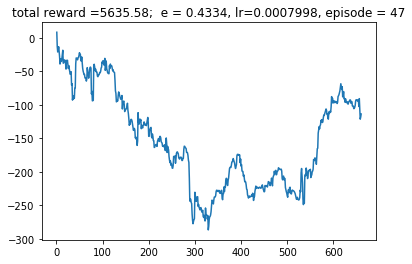

Waiting to train the whole dataset
action0:  280 
action1:  576 
action2:  1124
DONE, lets roll!!
74.826
More than 35 on candle 504
More than 35 on candle 695
More than 35 on candle 1562


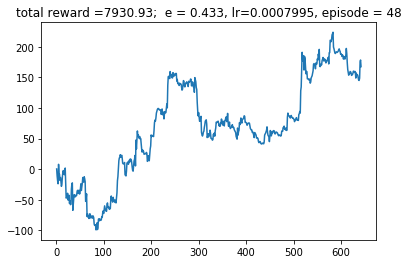

Waiting to train the whole dataset
action0:  280 
action1:  1423 
action2:  277
DONE, lets roll!!
74.811
More than 35 on candle 212
More than 35 on candle 699
More than 35 on candle 906


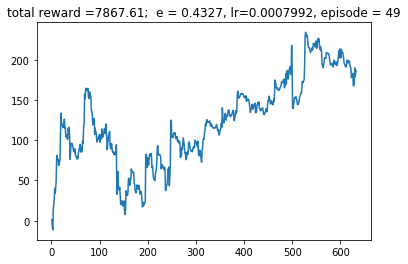

Waiting to train the whole dataset
action0:  280 
action1:  1262 
action2:  438
DONE, lets roll!!
73.698
More than 35 on candle 118
More than 35 on candle 217
More than 35 on candle 505


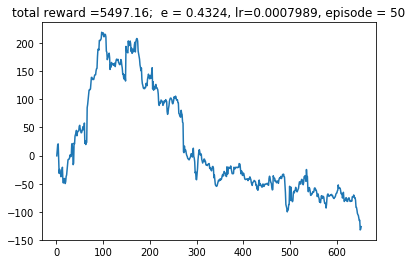

Waiting to train the whole dataset
action0:  289 
action1:  285 
action2:  1406
DONE, lets roll!!
74.59
More than 35 on candle 125
More than 35 on candle 214
More than 35 on candle 508
More than 35 on candle 904
More than 35 on candle 1487


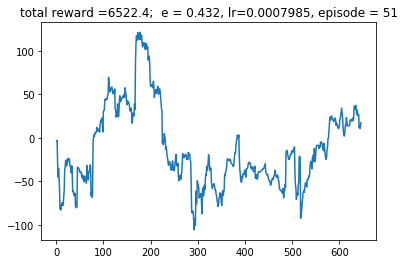

Waiting to train the whole dataset
action0:  314 
action1:  263 
action2:  1403
DONE, lets roll!!
75.636
More than 35 on candle 115
More than 35 on candle 505
More than 35 on candle 1574


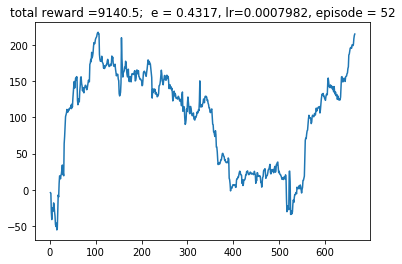

Waiting to train the whole dataset
action0:  256 
action1:  301 
action2:  1423
DONE, lets roll!!
74.917
More than 35 on candle 213


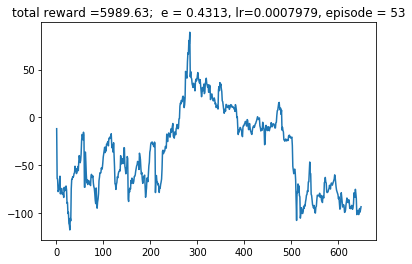

Waiting to train the whole dataset
action0:  249 
action1:  285 
action2:  1446
DONE, lets roll!!
75.609
More than 35 on candle 214
More than 35 on candle 1575


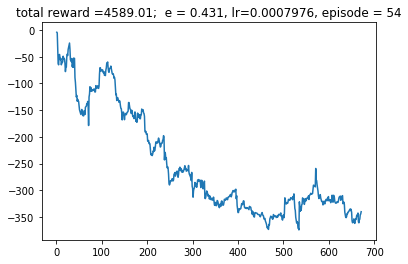

Waiting to train the whole dataset
action0:  280 
action1:  312 
action2:  1388
DONE, lets roll!!
74.3
More than 35 on candle 116
More than 35 on candle 504
More than 35 on candle 1576


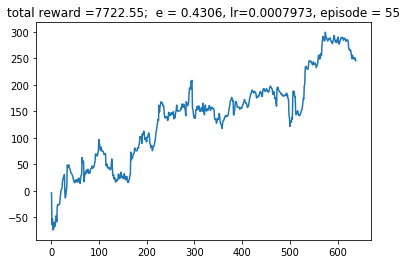

Waiting to train the whole dataset
action0:  293 
action1:  276 
action2:  1411
DONE, lets roll!!
75.115
More than 35 on candle 214
More than 35 on candle 505


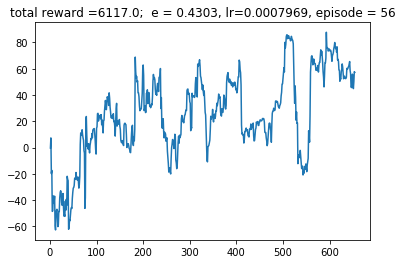

Waiting to train the whole dataset
action0:  282 
action1:  279 
action2:  1419
DONE, lets roll!!
76.722
More than 35 on candle 223


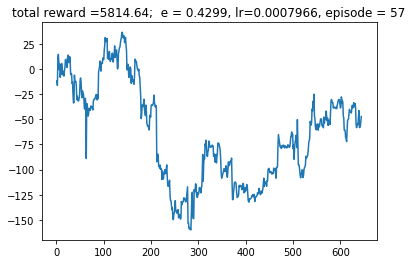

Waiting to train the whole dataset
action0:  259 
action1:  320 
action2:  1401
DONE, lets roll!!
74.921
More than 35 on candle 115
More than 35 on candle 505
More than 35 on candle 907


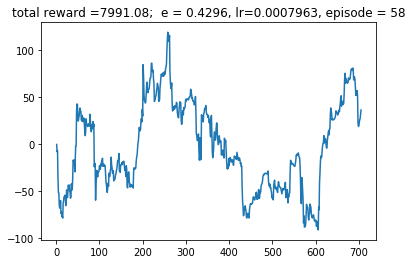

Waiting to train the whole dataset
action0:  267 
action1:  311 
action2:  1402
DONE, lets roll!!
74.666
More than 35 on candle 216
More than 35 on candle 1676


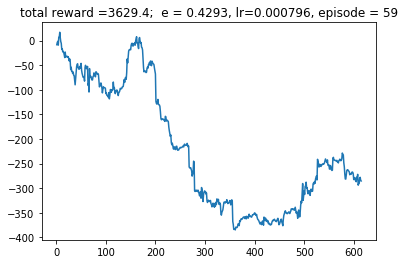

Waiting to train the whole dataset
action0:  311 
action1:  381 
action2:  1288
DONE, lets roll!!
74.299
More than 35 on candle 231
More than 35 on candle 508


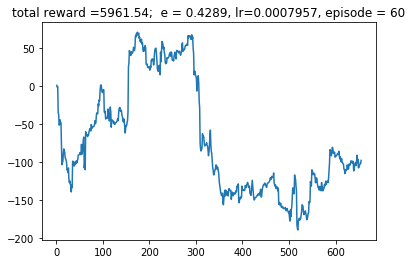

Waiting to train the whole dataset
action0:  278 
action1:  281 
action2:  1421
DONE, lets roll!!
76.231
More than 35 on candle 512


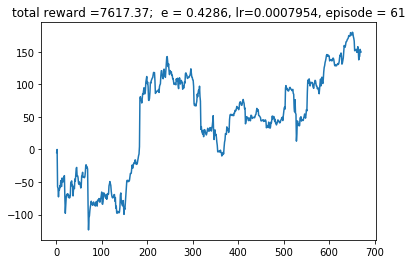

Waiting to train the whole dataset
action0:  275 
action1:  295 
action2:  1410
DONE, lets roll!!
75.616
More than 35 on candle 115
More than 35 on candle 510


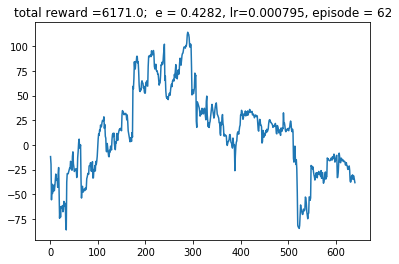

Waiting to train the whole dataset
action0:  289 
action1:  284 
action2:  1407
DONE, lets roll!!
74.014
More than 35 on candle 507
More than 35 on candle 1576


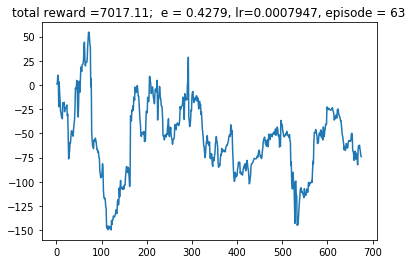

Waiting to train the whole dataset
action0:  285 
action1:  400 
action2:  1295
DONE, lets roll!!
73.474
More than 35 on candle 505
More than 35 on candle 899


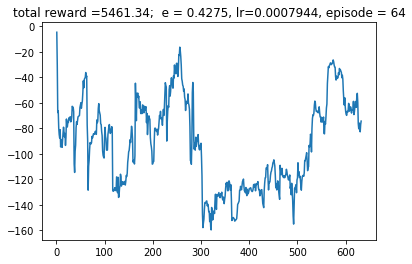

Waiting to train the whole dataset
action0:  296 
action1:  277 
action2:  1407
DONE, lets roll!!
75.069
More than 35 on candle 212
More than 35 on candle 505
More than 35 on candle 1676


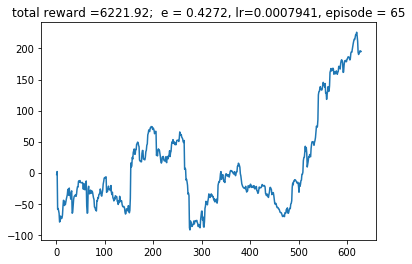

Waiting to train the whole dataset
action0:  275 
action1:  297 
action2:  1408
DONE, lets roll!!
75.397
More than 35 on candle 213
More than 35 on candle 504
More than 35 on candle 1579
More than 35 on candle 1679


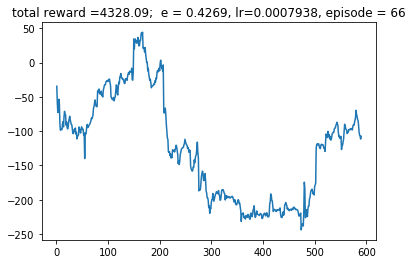

Waiting to train the whole dataset
action0:  253 
action1:  252 
action2:  1475
DONE, lets roll!!
75.01
More than 35 on candle 212
More than 35 on candle 507


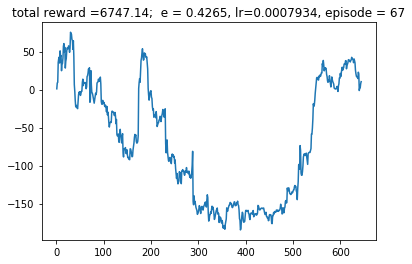

Waiting to train the whole dataset
action0:  316 
action1:  327 
action2:  1337
DONE, lets roll!!
74.559
More than 35 on candle 905


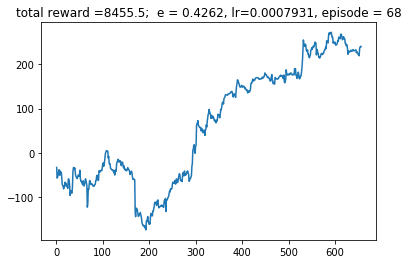

Waiting to train the whole dataset
action0:  294 
action1:  1074 
action2:  612
DONE, lets roll!!
75.112
More than 35 on candle 22
More than 35 on candle 206
More than 35 on candle 908


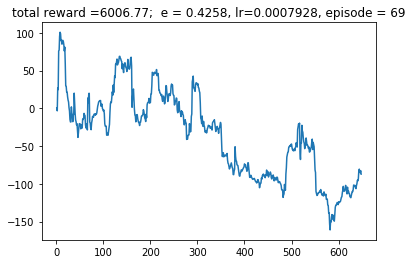

Waiting to train the whole dataset
action0:  267 
action1:  1310 
action2:  403
DONE, lets roll!!
75.443
More than 35 on candle 879


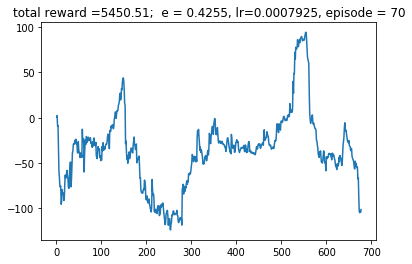

Waiting to train the whole dataset
action0:  276 
action1:  1211 
action2:  493
DONE, lets roll!!
77.348


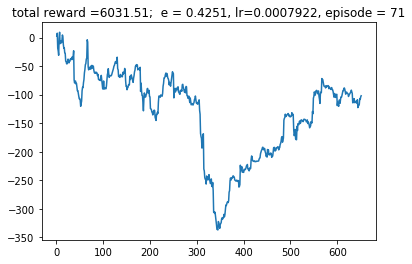

Waiting to train the whole dataset
action0:  261 
action1:  647 
action2:  1072
DONE, lets roll!!
78.106
More than 35 on candle 115
More than 35 on candle 504


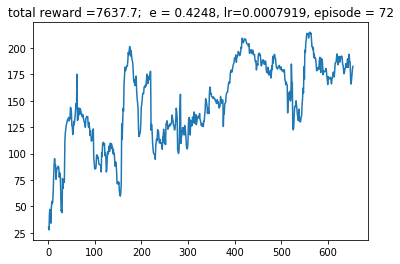

Waiting to train the whole dataset
action0:  258 
action1:  594 
action2:  1128
DONE, lets roll!!
81.333
More than 35 on candle 115
More than 35 on candle 506
More than 35 on candle 1573


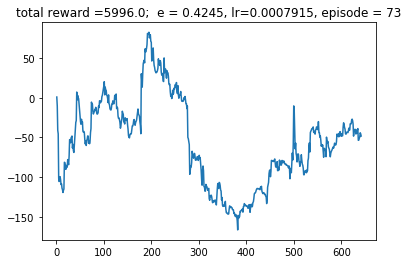

Waiting to train the whole dataset
action0:  296 
action1:  277 
action2:  1407
DONE, lets roll!!
77.328
More than 35 on candle 504
More than 35 on candle 880
More than 35 on candle 909


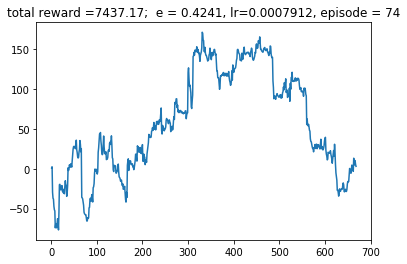

Waiting to train the whole dataset
action0:  294 
action1:  1032 
action2:  654
DONE, lets roll!!
76.833
More than 35 on candle 904


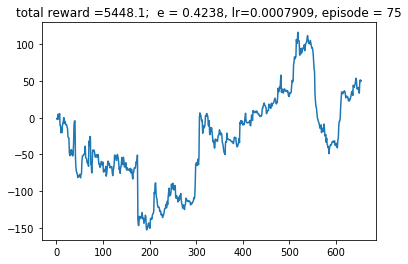

Waiting to train the whole dataset
action0:  308 
action1:  1415 
action2:  257
DONE, lets roll!!
77.156
More than 35 on candle 210
More than 35 on candle 699
More than 35 on candle 1584


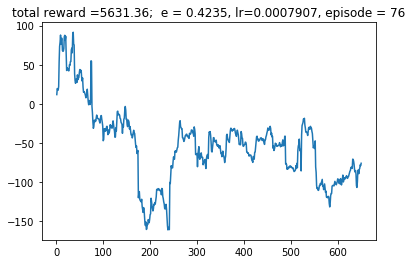

Waiting to train the whole dataset
action0:  299 
action1:  1403 
action2:  278
DONE, lets roll!!
80.55
More than 35 on candle 696
More than 35 on candle 905


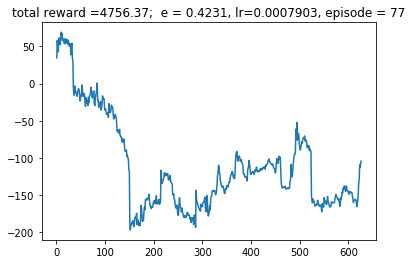

Waiting to train the whole dataset
action0:  274 
action1:  1434 
action2:  272
DONE, lets roll!!
80.624
More than 35 on candle 205
More than 35 on candle 212
More than 35 on candle 698
More than 35 on candle 905


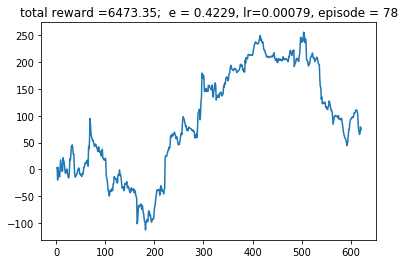

Waiting to train the whole dataset
action0:  290 
action1:  1240 
action2:  450
DONE, lets roll!!
80.472
More than 35 on candle 207
More than 35 on candle 878


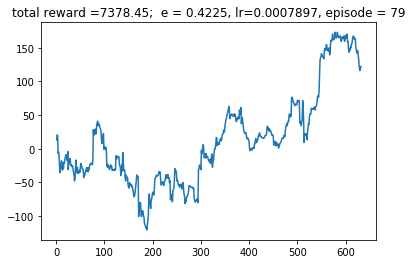

Waiting to train the whole dataset
action0:  291 
action1:  854 
action2:  835
DONE, lets roll!!
80.791
More than 35 on candle 904


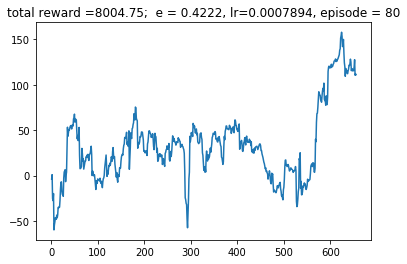

Waiting to train the whole dataset
action0:  293 
action1:  277 
action2:  1410
DONE, lets roll!!
81.367
More than 35 on candle 916
More than 35 on candle 983
More than 35 on candle 1671


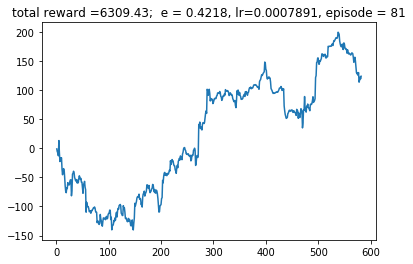

Waiting to train the whole dataset
action0:  276 
action1:  779 
action2:  925
DONE, lets roll!!
75.704
More than 35 on candle 115
More than 35 on candle 1674


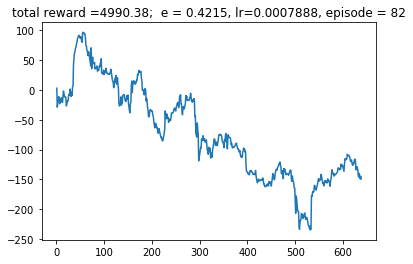

Waiting to train the whole dataset
action0:  284 
action1:  451 
action2:  1245
DONE, lets roll!!
75.273
More than 35 on candle 120
More than 35 on candle 507
More than 35 on candle 1585


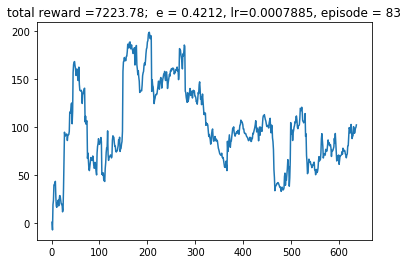

Waiting to train the whole dataset
action0:  282 
action1:  761 
action2:  937
DONE, lets roll!!
75.378
More than 35 on candle 14
More than 35 on candle 208
More than 35 on candle 698
More than 35 on candle 907


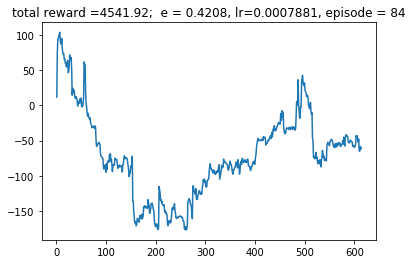

Waiting to train the whole dataset
action0:  291 
action1:  1421 
action2:  268
DONE, lets roll!!
82.402
More than 35 on candle 115
More than 35 on candle 212
More than 35 on candle 508


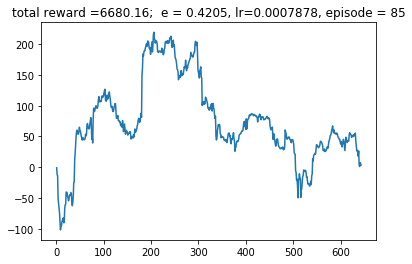

Waiting to train the whole dataset
action0:  285 
action1:  292 
action2:  1403
DONE, lets roll!!
83.169
More than 35 on candle 120
More than 35 on candle 1578


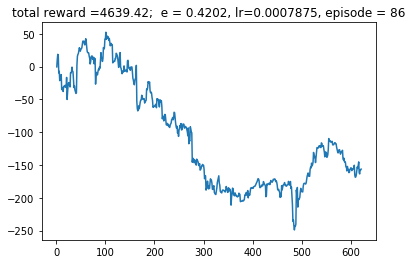

Waiting to train the whole dataset
action0:  281 
action1:  251 
action2:  1448
DONE, lets roll!!
79.371
More than 35 on candle 115
More than 35 on candle 212
More than 35 on candle 506


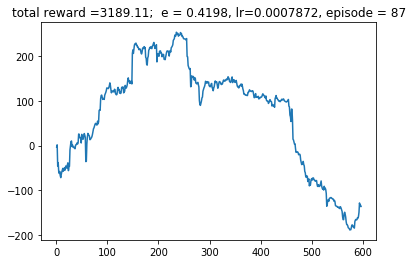

Waiting to train the whole dataset
action0:  280 
action1:  593 
action2:  1107
DONE, lets roll!!
78.482
More than 35 on candle 908
More than 35 on candle 982
More than 35 on candle 1591


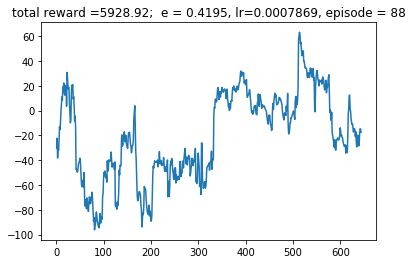

Waiting to train the whole dataset
action0:  281 
action1:  1188 
action2:  511
DONE, lets roll!!
76.187
More than 35 on candle 17
More than 35 on candle 694
More than 35 on candle 905
More than 35 on candle 1587


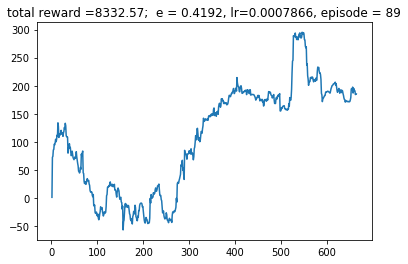

Waiting to train the whole dataset
action0:  293 
action1:  1396 
action2:  291
DONE, lets roll!!
77.128
More than 35 on candle 1682


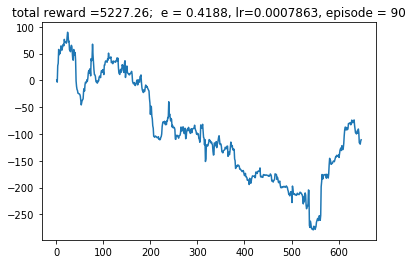

Waiting to train the whole dataset
action0:  267 
action1:  358 
action2:  1355
DONE, lets roll!!
76.889
More than 35 on candle 115
More than 35 on candle 213
More than 35 on candle 508
More than 35 on candle 1574


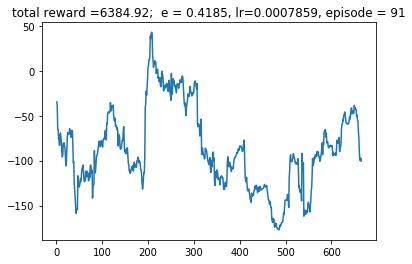

Waiting to train the whole dataset
action0:  317 
action1:  299 
action2:  1364
DONE, lets roll!!
75.487
More than 35 on candle 506
More than 35 on candle 904


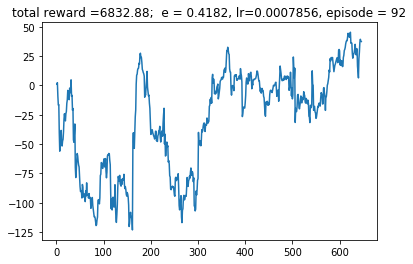

Waiting to train the whole dataset
action0:  259 
action1:  288 
action2:  1433
DONE, lets roll!!
75.012
More than 35 on candle 1673


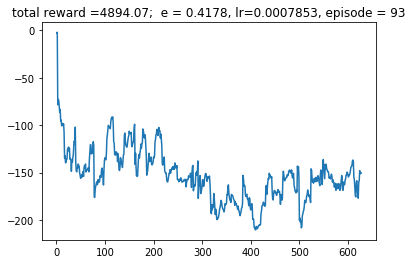

Waiting to train the whole dataset
action0:  268 
action1:  605 
action2:  1107
DONE, lets roll!!
79.028
More than 35 on candle 116
More than 35 on candle 213
More than 35 on candle 507
More than 35 on candle 1688


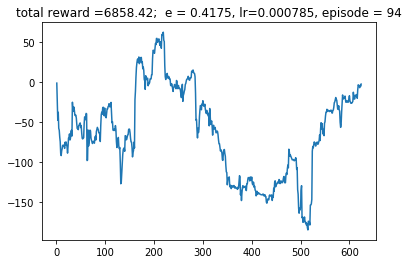

Waiting to train the whole dataset
action0:  294 
action1:  279 
action2:  1407
DONE, lets roll!!
77.141
More than 35 on candle 120


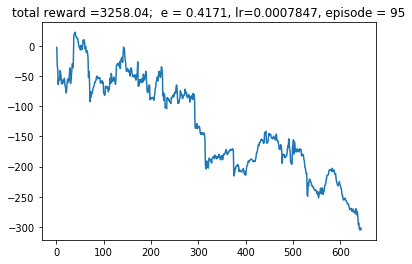

Waiting to train the whole dataset
action0:  282 
action1:  734 
action2:  964
DONE, lets roll!!
77.678
More than 35 on candle 64
More than 35 on candle 510


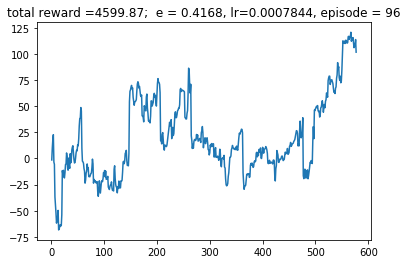

Waiting to train the whole dataset
action0:  291 
action1:  262 
action2:  1427
DONE, lets roll!!
77.321
More than 35 on candle 509
More than 35 on candle 1677


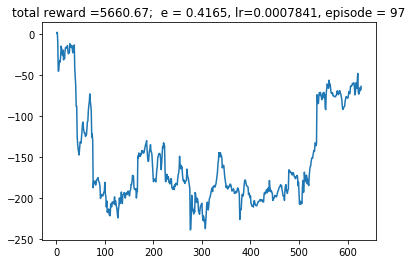

Waiting to train the whole dataset
action0:  270 
action1:  403 
action2:  1307
DONE, lets roll!!
76.491
More than 35 on candle 216
More than 35 on candle 880
More than 35 on candle 915


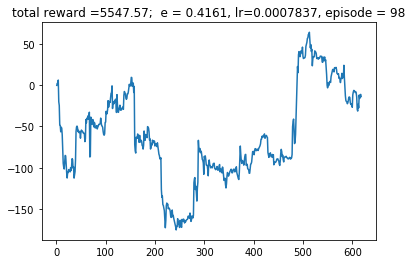

Waiting to train the whole dataset
action0:  292 
action1:  997 
action2:  691
DONE, lets roll!!
77.965
More than 35 on candle 115
More than 35 on candle 697
More than 35 on candle 905


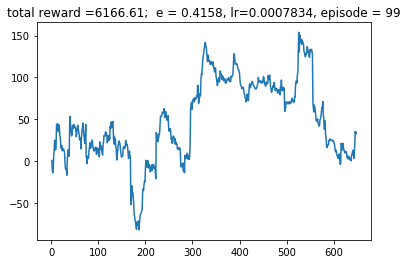

Waiting to train the whole dataset
action0:  309 
action1:  1414 
action2:  257
DONE, lets roll!!
75.937
More than 35 on candle 214
More than 35 on candle 904


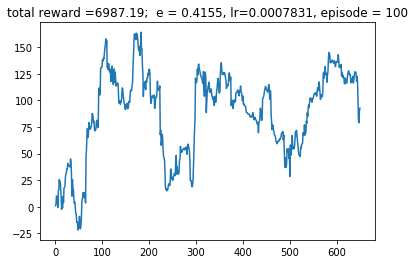

Waiting to train the whole dataset
action0:  284 
action1:  274 
action2:  1422
DONE, lets roll!!
76.377
More than 35 on candle 214
More than 35 on candle 508


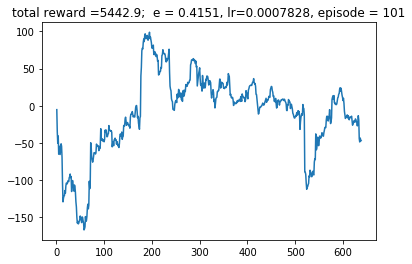

Waiting to train the whole dataset
action0:  255 
action1:  275 
action2:  1450
DONE, lets roll!!
78.907
More than 35 on candle 14
More than 35 on candle 907


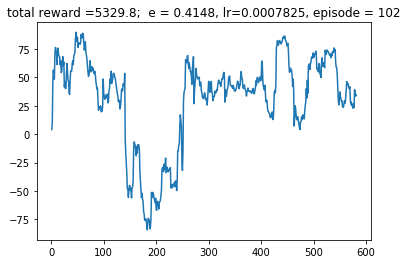

Waiting to train the whole dataset
action0:  283 
action1:  956 
action2:  741
DONE, lets roll!!
75.76
More than 35 on candle 213
More than 35 on candle 517
More than 35 on candle 904
More than 35 on candle 1587


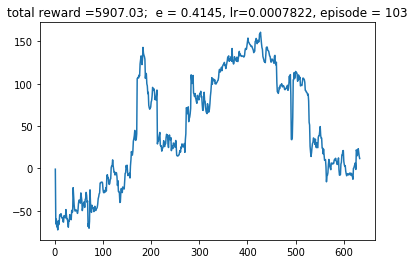

Waiting to train the whole dataset
action0:  274 
action1:  914 
action2:  792
DONE, lets roll!!
74.531
More than 35 on candle 24
More than 35 on candle 695
More than 35 on candle 905


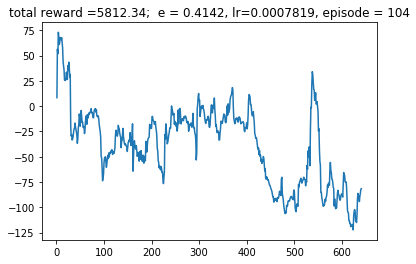

Waiting to train the whole dataset
action0:  266 
action1:  1427 
action2:  287
DONE, lets roll!!
76.465


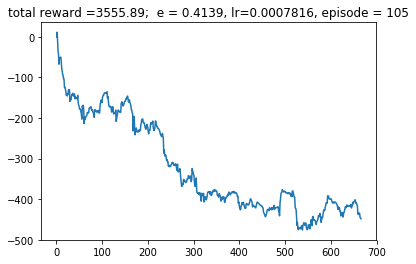

Waiting to train the whole dataset
action0:  248 
action1:  396 
action2:  1336
DONE, lets roll!!
75.449
More than 35 on candle 514
More than 35 on candle 695
More than 35 on candle 1190


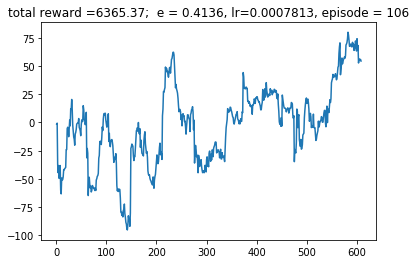

Waiting to train the whole dataset
action0:  258 
action1:  674 
action2:  1048
DONE, lets roll!!
76.146
More than 35 on candle 208
More than 35 on candle 904
More than 35 on candle 1579


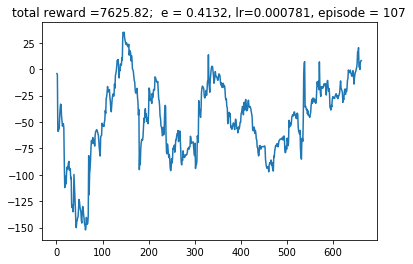

Waiting to train the whole dataset
action0:  276 
action1:  514 
action2:  1190
DONE, lets roll!!
75.895
More than 35 on candle 60


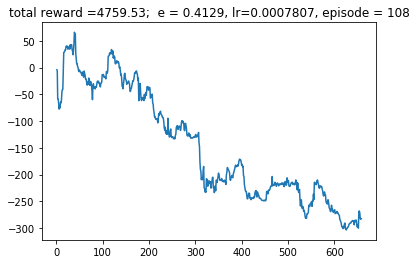

Waiting to train the whole dataset
action0:  257 
action1:  568 
action2:  1155
DONE, lets roll!!
76.684
More than 35 on candle 206


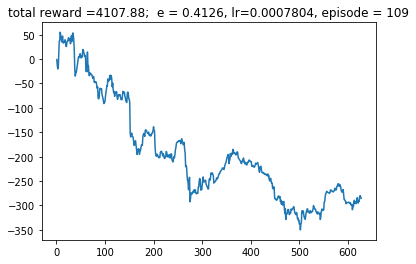

Waiting to train the whole dataset
action0:  274 
action1:  670 
action2:  1036
DONE, lets roll!!
75.621
More than 35 on candle 116
More than 35 on candle 206
More than 35 on candle 505
More than 35 on candle 888
More than 35 on candle 909
More than 35 on candle 1189


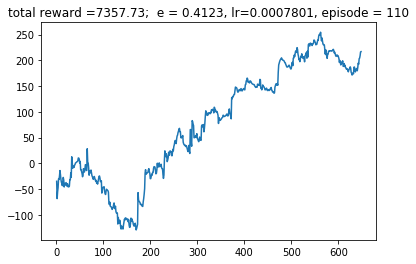

Waiting to train the whole dataset
action0:  287 
action1:  1034 
action2:  659
DONE, lets roll!!
76.013
More than 35 on candle 117
More than 35 on candle 214
More than 35 on candle 504
More than 35 on candle 1673


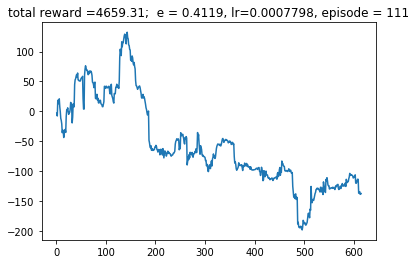

Waiting to train the whole dataset
action0:  279 
action1:  368 
action2:  1333
DONE, lets roll!!
76.604
More than 35 on candle 115
More than 35 on candle 212
More than 35 on candle 507
More than 35 on candle 1580
More than 35 on candle 1682


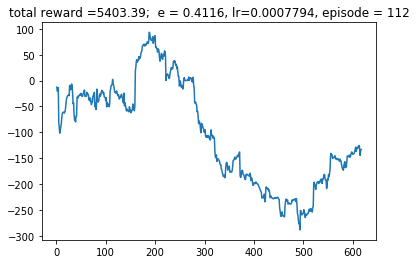

Waiting to train the whole dataset
action0:  242 
action1:  288 
action2:  1450
DONE, lets roll!!
77.371
More than 35 on candle 505
More than 35 on candle 1674


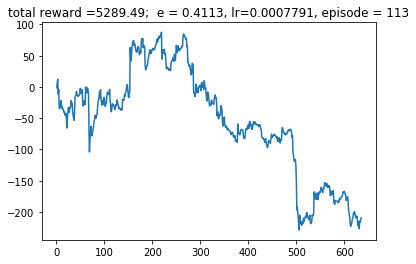

Waiting to train the whole dataset
action0:  252 
action1:  579 
action2:  1149
DONE, lets roll!!
75.885
More than 35 on candle 509
More than 35 on candle 904


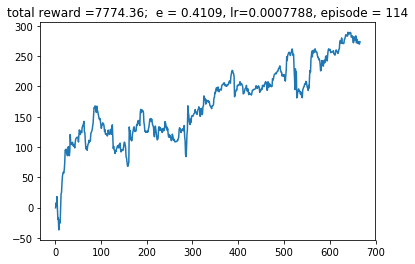

Waiting to train the whole dataset
action0:  294 
action1:  301 
action2:  1385
DONE, lets roll!!
77.463


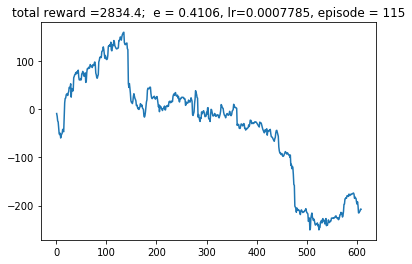

Waiting to train the whole dataset
action0:  288 
action1:  744 
action2:  948
DONE, lets roll!!
75.269
More than 35 on candle 12
More than 35 on candle 115
More than 35 on candle 207
More than 35 on candle 697
More than 35 on candle 1670


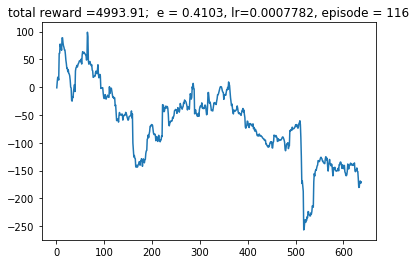

Waiting to train the whole dataset
action0:  308 
action1:  637 
action2:  1035
DONE, lets roll!!
74.786
More than 35 on candle 212
More than 35 on candle 694
More than 35 on candle 911


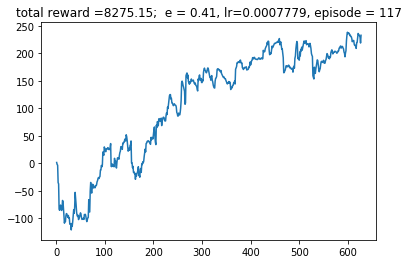

Waiting to train the whole dataset
action0:  263 
action1:  1130 
action2:  587
DONE, lets roll!!
75.944
More than 35 on candle 206
More than 35 on candle 908
More than 35 on candle 982


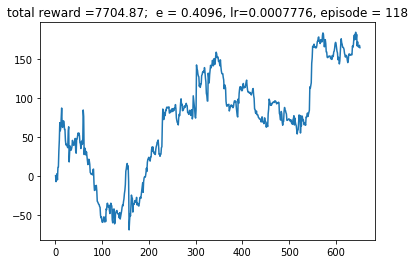

Waiting to train the whole dataset
action0:  265 
action1:  997 
action2:  718
DONE, lets roll!!
75.384
More than 35 on candle 62
More than 35 on candle 115
More than 35 on candle 207
More than 35 on candle 213
More than 35 on candle 504
More than 35 on candle 904
More than 35 on candle 1555


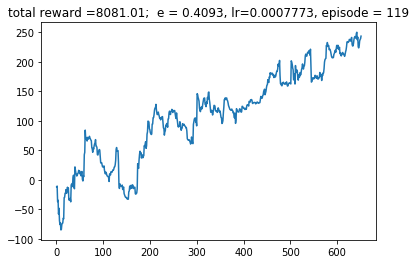

Waiting to train the whole dataset
action0:  273 
action1:  1113 
action2:  594
DONE, lets roll!!
75.589
More than 35 on candle 704


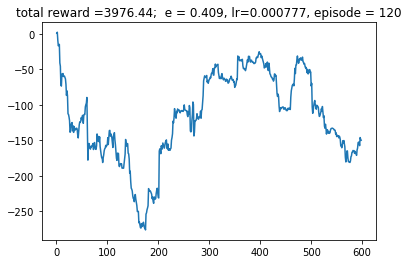

Waiting to train the whole dataset
action0:  262 
action1:  1212 
action2:  506
DONE, lets roll!!
76.386
More than 35 on candle 13
More than 35 on candle 904
More than 35 on candle 1673


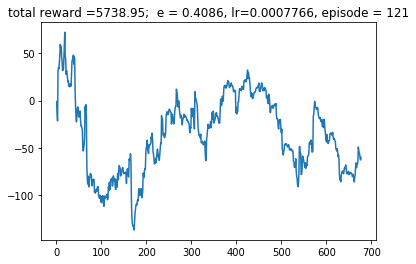

Waiting to train the whole dataset
action0:  286 
action1:  874 
action2:  820
DONE, lets roll!!
76.131
More than 35 on candle 213


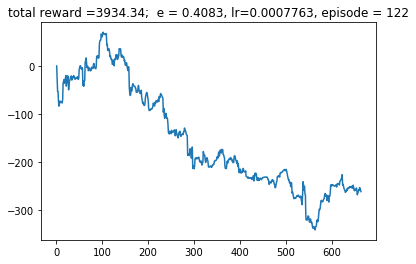

Waiting to train the whole dataset
action0:  294 
action1:  300 
action2:  1386
DONE, lets roll!!
76.215
More than 35 on candle 221


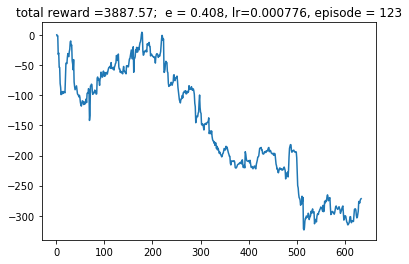

Waiting to train the whole dataset
action0:  264 
action1:  714 
action2:  1002
DONE, lets roll!!
75.483
More than 35 on candle 701


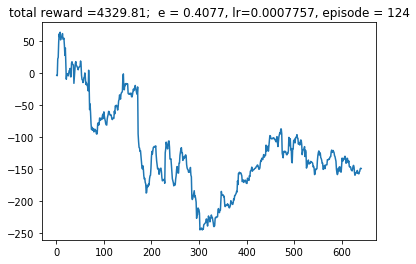

Waiting to train the whole dataset
action0:  276 
action1:  1276 
action2:  428
DONE, lets roll!!
75.263
More than 35 on candle 11
More than 35 on candle 695


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > osmdesat * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than {} on candle {}'.format(osmdesat, time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))